In [19]:
from scipy.io import loadmat

loaded_dataset = loadmat("dataset_liver_bmodes_steatosis_assessment_IJCARS.mat")

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

In [21]:
def enhance_image(image):
    image = np.uint8(image)
    image = cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    scaled_image = (image / np.max(image)) * 255
    scaled_image = scaled_image.astype(np.uint8)

    # Apply adaptive histogram equalization (CLAHE) to enhance local contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(scaled_image.astype(np.uint8))

    # Apply bilateral filtering for noise reduction while preserving edges
    enhanced_image = cv2.bilateralFilter(enhanced_image, 15, 50, 50)

    # Apply sharpening using the Laplacian filter
    laplacian = cv2.Laplacian(enhanced_image, cv2.CV_64F)
    sharpened_image = np.uint8(np.clip(enhanced_image - 0.5 * laplacian, 0, 255))
    normalized_image = cv2.normalize(
        sharpened_image,
        None,
        alpha=0,
        beta=1,
        norm_type=cv2.NORM_MINMAX,
        dtype=cv2.CV_32F,
    )

    return normalized_image

## Setting up dataset and creating image files

In [103]:
data = loaded_dataset["data"]
data_records = {"id": [], "fat": [], "class": [], "images": []}

for record in range(55):
    id_ = data["id"][0][record][0][0]
    fat = data["fat"][0][record][0][0]
    cat = data["class"][0][record][0][0]
    imgs = data["images"][0][record]

    for index, im in enumerate(imgs):
        filename = f"{id_}_{cat}_{fat}_{index}.jpg"
        enhanced_im = enhance_image(im.astype(np.uint8))

        # cropping the image for region of interest
        roi_im = enhanced_im[300:700, 170:800]

        # to save images:
        # plt.imsave(f"og/{filename}", im.astype(np.uint8),cmap="grey" )
        # plt.imsave(f"enh/{filename}", enhanced_im, cmap="grey" )
        # plt.imsave(f"roi/{filename}", roi_im, cmap="grey")
        roi_im = roi_im.astype(np.uint8)

        data_records["id"].append(id_)
        data_records["fat"].append(fat)
        data_records["class"].append(cat)
        # data_records["images"].append(roi_im)
        data_records["images"].append(enhanced_im)


df = pd.DataFrame(data_records)

In [72]:
enhanced_im.shape

(868, 1272)

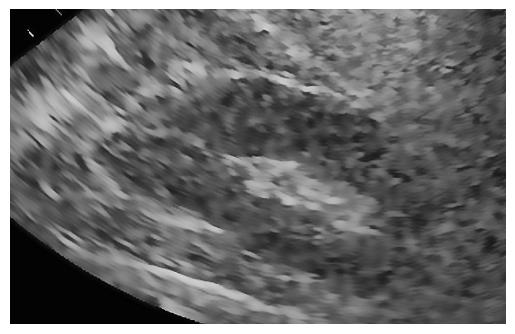

In [94]:
roi_im = enhanced_im[300:700, 170:800]

# Display the image
plt.imshow(roi_im, cmap="gray")
plt.axis("off")
plt.show()

### GLCM features

In [104]:
from skimage.feature import graycomatrix, graycoprops


# Define function to compute GLCM features for a single image
def compute_glcm_features(image):

    image = image.astype(np.uint8)
    distances = [1, 2, 3]  # Define distances for GLCM computation
    angles = [
        0,
        np.pi / 4,
        np.pi / 2,
        3 * np.pi / 4,
    ]  # Define angles for GLCM computation
    glcm = graycomatrix(
        image, distances=distances, angles=angles, symmetric=True, normed=True
    )

    # Compute GLCM properties
    contrast = graycoprops(glcm, "contrast").ravel()
    energy = graycoprops(glcm, "energy").ravel()
    homogeneity = graycoprops(glcm, "homogeneity").ravel()
    correlation = graycoprops(glcm, "correlation").ravel()

    # Concatenate GLCM features
    glcm_features = np.concatenate([contrast, energy, homogeneity, correlation])
    return glcm_features

In [106]:
images = df["images"].values

# Compute GLCM features for each image
glcm_features = [compute_glcm_features(image.astype(np.uint8)) for image in images]

# Concatenate GLCM features into a feature matrix
feature_matrix = np.array(glcm_features)

In [ ]:
y = df['class']

In [107]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In [108]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import seaborn as sns

def get_best_model(X, y, n_comp, num_folds=7):

    # Define the number of folds for cross-validation
    accuracy_scores = []
    auc_scores = []
    conf_matrices = []
    classification_reports = []

    # Initialize a StratifiedKFold object
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    # Initialize a PCA object
    pca = PCA(n_components=n_comp)

    # Initialize a Random Forest classifier
    clf = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        max_depth=10,
        min_samples_leaf=1,
        min_samples_split=5,
        criterion="entropy",
    )

    # Perform cross-validation
    for train_index, test_index in kf.split(X, y=y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Apply PCA to the training and test data
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        # Train the classifier
        clf.fit(X_train_pca, y_train)

        # Make predictions
        y_pred = clf.predict(X_test_pca)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        # Calculate ROC-AUC score
        auc = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc)

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrices.append(conf_matrix)

        # Calculate classification report
        cls_report = classification_report(y_test, y_pred)
        classification_reports.append(cls_report)

    # Calculate the mean accuracy score across all folds
    mean_accuracy = np.mean(accuracy_scores)
    print("Mean Accuracy:", mean_accuracy)
    print("Best Accuracy:", max(accuracy_scores))
    
    # Print average ROC-AUC score
    mean_auc = np.mean(auc_scores)
    print("Mean ROC-AUC Score:", mean_auc)
    
    # Print average confusion matrix
    mean_conf_matrix = np.mean(conf_matrices, axis=0)
    print("Mean Confusion Matrix:\n", mean_conf_matrix)
    

    # Assuming y_true and y_pred are your true labels and predicted labels
    # Calculate confusion matrix

    # Define class labels
    class_names = ['No Disease', 'Disease']

    # Plot confusion matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(mean_conf_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


    # Print average classification report
    print("Mean Classification Report:\n", classification_reports[0])  # Assuming same report for all folds
    
    return clf


Mean Accuracy: 0.9037418277924607
Best Accuracy: 0.9487179487179487
Mean ROC-AUC Score: 0.8559559884559885
Mean Confusion Matrix:
 [[17.71428571  6.57142857]
 [ 1.         53.28571429]]


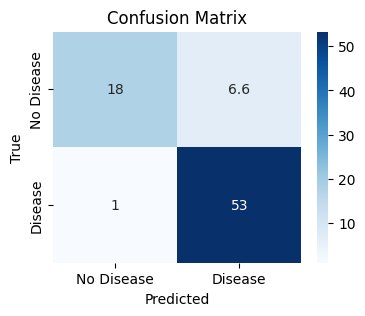

Mean Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.72      0.84        25
           1       0.89      1.00      0.94        54

    accuracy                           0.91        79
   macro avg       0.94      0.86      0.89        79
weighted avg       0.92      0.91      0.91        79



In [109]:
model = get_best_model(feature_matrix, y, 11, 7)

PCA(MLE) gives better accuracy and stuff that any other methods

Mean Accuracy: 0.9254880140956091
Best Accuracy: 0.9615384615384616
Mean ROC-AUC Score: 0.8878631553631554
Mean Confusion Matrix:
 [[19.14285714  5.14285714]
 [ 0.71428571 53.57142857]]


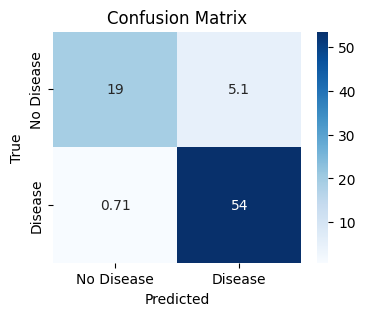

Explained Variance Ratio: 0.9999999999991811
Mean Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.76      0.86        25
           1       0.90      1.00      0.95        54

    accuracy                           0.92        79
   macro avg       0.95      0.88      0.91        79
weighted avg       0.93      0.92      0.92        79



In [118]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import seaborn as sns

def get_best_model1(X, y, num_folds=7):

    # Define the number of folds for cross-validation
    accuracy_scores = []
    auc_scores = []
    conf_matrices = []
    classification_reports = []

    # Initialize a StratifiedKFold object
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    # Initialize a PCA object
    pca = PCA(n_components="mle")

    # Initialize a Random Forest classifier
    clf = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        max_depth=10,
        min_samples_leaf=1,
        min_samples_split=5,
        criterion="entropy",
    )

    # Perform cross-validation
    for train_index, test_index in kf.split(X, y=y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Apply PCA to the training and test data
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        # Train the classifier
        clf.fit(X_train_pca, y_train)

        # Make predictions
        y_pred = clf.predict(X_test_pca)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

        # Calculate ROC-AUC score
        auc = roc_auc_score(y_test, y_pred)
        auc_scores.append(auc)

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrices.append(conf_matrix)

        # Calculate classification report
        cls_report = classification_report(y_test, y_pred)
        classification_reports.append(cls_report)

    # Calculate the mean accuracy score across all folds
    mean_accuracy = np.mean(accuracy_scores)
    print("Mean Accuracy:", mean_accuracy)
    print("Best Accuracy:", max(accuracy_scores))
    
    # Print average ROC-AUC score
    mean_auc = np.mean(auc_scores)
    print("Mean ROC-AUC Score:", mean_auc)
    
    # Print average confusion matrix
    mean_conf_matrix = np.mean(conf_matrices, axis=0)
    print("Mean Confusion Matrix:\n", mean_conf_matrix)
    

    # Assuming y_true and y_pred are your true labels and predicted labels
    # Calculate confusion matrix

    # Define class labels
    class_names = ['No Disease', 'Disease']

    # Plot confusion matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(mean_conf_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print("Explained Variance Ratio:", sum(pca.explained_variance_ratio_))

    # Print average classification report
    print("Mean Classification Report:\n", classification_reports[0])  # Assuming same report for all folds
    
    return clf
model = get_best_model1(feature_matrix, y, 7)


Explained Variance Ratio: 11
